In [17]:
import toytree
import pandas as pd
import numpy as np
import ipcoal
import ipyrad.analysis as ipa
import tempfile
import subprocess
import matplotlib.pyplot as plt

In [2]:
tre = toytree.rtree.unittree(12, treeheight = 10e6, seed = 102)
tree = tre.write("/home/henry/phylo-timescale/tree.tre")

ttree = toytree.tree("/home/henry/phylo-timescale/tree.tre")
ttree.draw(node_labels="idx", node_sizes=12);

<svg class="toyplot-canvas-Canvas" height="275.0px" id="td60d8a86c6fe4157b3f95c5c24c0dea7" preserveAspectRatio="xMidYMid meet" style="background-color:transparent;border-color:#292724;border-style:none;border-width:1.0;fill:rgb(16.1%,15.3%,14.1%);fill-opacity:1.0;font-family:Helvetica;font-size:12px;opacity:1.0;stroke:rgb(16.1%,15.3%,14.1%);stroke-opacity:1.0;stroke-width:1.0" viewBox="0 0 265.0 275.0" width="265.0px" xmlns="http://www.w3.org/2000/svg" xmlns:toyplot="http://www.sandia.gov/toyplot" xmlns:xlink="http://www.w3.org/1999/xlink"> 12 13 14 15 16 17 18 19 20 21 r0 r1 r2 r3 r4 r5 r6 r7 r8 r9 r10 r11

In [66]:
class Simulator:
    
    def __init__(self, seed, sptree, ntrees):
        
        # Store initial arguments.
        self.seed = seed # Seed for all instances of the class.  
        self.sptree = sptree # True species tree.
        self.ntrees = ntrees # Number of replicate trees.
        # self.ntips = ntips  Number of tips.
        
        # Objects to be created.
        self.reps = []
        self.seqs = []
        self.raxtrees = []
        
        # Organize results into a dataframe.
        self.df = pd.DataFrame({
            
            # Trees with rate variation applied to edges.
            "rate_trees": ["" for i in range(ntrees)],
            
            # Gene trees with variable edge lengths inferred by RAxML.
            "rax_trees": ["" for i in range(ntrees)],
            
            # Number of SNPs from RAxML trees.
            "nsnps": 0,

            # Ultrametric trees inferred from chronos under relaxed model.
            "chr_trees_relax": ["" for i in range(ntrees)],
            
            # # Ultrametric trees inferred from chronos under strict model.
            "chr_trees_strict": ["" for i in range(ntrees)],
            
            # Error between tree from chronos and true tree.
            "error" : ["" for i in range(ntrees)]
        })
        
    # Execute all the major functions in a row.
    def run(self, outdir, file_marker, path, min_ages, max_ages, tips, lamb):
        self.batch_treedata()
        self.batch_ipcoal()
        self.batch_raxml()
        self.batch_chronos()

    def batch_treedata(self, outdir, file_marker):
        '''
        Apply rate variation to the edges of the species tree.
        '''
        
        np.random.seed(self.seed)
        self.reps = [self.sptree for i in range(self.ntrees)]
        reps = []
        counter = 0
        for i in self.reps:
        
            # Increment counter.
            counter +=1
    
            # Set Ne values from an interval onto tree.
            dict_ne = {j.name : np.random.randint(5e5, 5e6) for j in i.get_feature_dict()}
            i = i.set_node_values("Ne", dict_ne)
    
            # Set g values from a normal distribution onto tree.
            dict_g = {j.name : np.random.normal(1, 0.2) for j in i.get_feature_dict()}
            i = i.set_node_values("g", dict_g)
    
            # Divide edge lengths (absolute time) by generation time to convert tree to units of generations.
            i = i.set_node_values(
            "dist",
            {j.name: j.dist / j.g for j in i.get_feature_dict()}
            )
    
            # Save tree to a list and as a separate newick file.
            reps.append(i)
            savefile = outdir + file_marker + '{0:03}'.format(counter) + ".tre"
            i.write(savefile)
            
        # Save to instance variable and dataframe.
        self.reps = reps
        for i in self.df.index:
            self.df.loc[i, "rate_trees"] = self.reps[i]
    
        return "Saved " + str(self.ntrees) + " trees."
    
    def batch_ipcoal(self, outdir, file_marker):
        '''
        Generate sequence data on tree variants.
        '''
        
        counter = 0
        seqs = []
        for i in self.reps:
        
            # Increment counter.
            counter += 1
        
            # Run ipcoal.
            model = ipcoal.Model(i, nsamples = 2, seed = self.seed) 
            model.sim_loci(1000, 100) # (loci, bp) 
            
            # Write a diploid phylip file.
            file = model.write_concat_to_phylip(outdir = outdir, diploid = True,
                                      name = file_marker + "_diploid" + '{0:03}'.format(counter) + ".phy")
            seqs.append(outdir + file_marker + "_diploid" + '{0:03}'.format(counter) + ".phy")
            
        # Save the list of concatenated phylip files to instance variable.   
        self.seqs = seqs
            
    def batch_raxml(self, outdir, file_marker, outdir_for_chronos):
        '''
        Infer raxml trees from sequence data.
        '''
        
        np.random.seed(self.seed)
        raxtrees = []
        counter = 0
        for i in self.seqs:
        
            # Increment counter.
            counter += 1
        
            # Define and run raxml object.
            rax = ipa.raxml(
                name = file_marker + '{0:03}'.format(counter),
                data = i,
                workdir = outdir,
                N = 100,
                T = 10 # Core assignment appropriate for pinky or other external server.
            )
            rax.run(force = True, block = False)
            
            # Take the raxml result and save as a newick string (required format for chronos).
            rax_result = outdir + "RAxML_bipartitions." + file_marker + '{0:03}'.format(counter)
            rax_toytree = toytree.tree(rax_result).root(["r7", "r8", "r9", "r10", "r11"]) # Rooting midpoint of true tree.
            rax_toytree.write(outdir_for_chronos + file_marker + '{0:03}'.format(counter) + ".tre")
            
            # Add raxtree to list.
            # raxtrees.append(outdir_for_chronos + file_marker + '{0:03}'.format(counter) + ".tre")
            raxtrees.append(rax_toytree)
            
        # Save to instance variable and dataframe.
        self.raxtrees = raxtrees
        for i in self.df.index:
            self.df.loc[i, "rax_trees"] = self.raxtrees[i]
            
class Analysis:
    
    def __init__(self, seed, sptree, df):
        
        # Store initial arguments.
        self.seed = seed
        self.sptree = sptree
        self.df = df
        
        # Objects to be created.
        self.chrtrees = []
        self.errors = []
        
    def batch_chronos(self, path_with_marker, min_ages, max_ages, tip1, tip2, lamb):
        '''
        Run chronos on raxml trees.  Format min_ages, max_ages, tip1 and tip2 as tuples of the same length, formatted with
        double quotes enclosing parentheses, with constituent elements in single quotes.
        Examples: min_ages = "('5000000', '10000000')"; tip1 = "('r0', 'r4')"
        '''
    
        np.random.seed(self.seed)
        chrtrees = []
        counter = 0
        for i in self.df["rax_trees"]:
        
            # Increment counter.
            counter += 1
        
            # Rstring with chronos information.
            rstring = f"""library(ape)
btree <- read.tree("{i}")
min_ages <- c{min_ages}
max_ages <- c{max_ages}
tip1 <- c{tip1}
tip2 <- c{tip2}
nodes <- c()
for (i in 1:length(tip1)) {{
    mrca <- getMRCA(btree, c(tip1[i], tip2[i]))
    nodes <- append(nodes, mrca)
}}
calib <- data.frame(node = nodes, age.min = as.numeric(min_ages), age.max = as.numeric(max_ages))
ctree <- chronos(btree, lambda = {lamb}, model = "relaxed", calibration = calib)
write.tree(ctree)"""
            
            # Write the R script to a file.
            with open(path_with_marker + '{0:03}'.format(counter) + ".R", 'w') as out:
                out.write(rstring)
            
            # byte = rstring.encode()
            # temp = tempfile.NamedTemporaryFile()
            # temp.write(byte)
            # temp.seek(0)
            # print(temp.read())
    
            cmd = ["Rscript", path_with_marker + '{0:03}'.format(counter) + ".R"] # Runs R script saved to path.
            out = subprocess.check_output(cmd).decode()
            results, tree = [i.strip().strip('"') for i in out.split("[1]")]

            # Add chronos tree to list.
            chrtrees.append(tree)
            
            # temp.close()
    
        # Save to instance variable and dataframe.
        self.chrtrees = chrtrees
        for i in self.df.index:
            self.df.loc[i, "chr_trees_relax"] = self.chrtrees[i]
    
    def calculate_error(self):
        "Calculate error between true tree and chronos trees."
        
        errors = []
        
        # Get edge lengths of true tree.
        true_edge_lengths = self.sptree.get_edge_values(feature = "height")
        
        # For each chrtree, get edge lengths to subtract from true edge lengths.
        for i in self.chrtrees:
            chrtree = toytree.tree(i)
            chr_edge_lengths = chrtree.get_edge_values(feature = "height")
            subtract_array = true_edge_lengths - chr_edge_lengths
            
            # Square each element in the array.
            squared_array = np.square(subtract_array)
            
            # Sum all elements in the array (sum of squares).
            sum_squares = np.sum(squared_array)
            
            # Add error to list.
            errors.append(sum_squares)
            
        # Save to instance variable and dataframe.
        self.errors = errors
        for i in self.df.index:
            self.df.loc[i, "error"] = self.errors[i]
    
    def batch_mrbayes(self):
        "call mrbayes (maybe using ipa) to infer trees"
        pass

In [4]:
# Initialize instance of class.
sim = Simulator(seed = 234, sptree = ttree, ntrees = 100)

In [5]:
sim.batch_treedata("/pinky/henry/vary-g/treedata/", "ttree")

'Saved 100 trees.'

In [ ]:
sim.batch_ipcoal("/pinky/henry/vary-g/ipcoal/", "ttree")

wrote concat locus (12 x 100000bp) to /pinky/henry/vary-g/ipcoal/ttree_diploid001.phy
wrote concat locus (12 x 100000bp) to /pinky/henry/vary-g/ipcoal/ttree_diploid002.phy
wrote concat locus (12 x 100000bp) to /pinky/henry/vary-g/ipcoal/ttree_diploid003.phy
wrote concat locus (12 x 100000bp) to /pinky/henry/vary-g/ipcoal/ttree_diploid004.phy
wrote concat locus (12 x 100000bp) to /pinky/henry/vary-g/ipcoal/ttree_diploid005.phy
wrote concat locus (12 x 100000bp) to /pinky/henry/vary-g/ipcoal/ttree_diploid006.phy
wrote concat locus (12 x 100000bp) to /pinky/henry/vary-g/ipcoal/ttree_diploid007.phy
wrote concat locus (12 x 100000bp) to /pinky/henry/vary-g/ipcoal/ttree_diploid008.phy
wrote concat locus (12 x 100000bp) to /pinky/henry/vary-g/ipcoal/ttree_diploid009.phy
wrote concat locus (12 x 100000bp) to /pinky/henry/vary-g/ipcoal/ttree_diploid010.phy
wrote concat locus (12 x 100000bp) to /pinky/henry/vary-g/ipcoal/ttree_diploid011.phy
wrote concat locus (12 x 100000bp) to /pinky/henry/var

In [7]:
sim.batch_raxml("/pinky/henry/vary-g/raxml/", "ttree", 
                "/pinky/henry/vary-g/pre-chronos/")

job ttree001 finished successfully
job ttree002 finished successfully
job ttree003 finished successfully
job ttree004 finished successfully
job ttree005 finished successfully
job ttree006 finished successfully
job ttree007 finished successfully
job ttree008 finished successfully
job ttree009 finished successfully
job ttree010 finished successfully
job ttree011 finished successfully
job ttree012 finished successfully
job ttree013 finished successfully
job ttree014 finished successfully
job ttree015 finished successfully
job ttree016 finished successfully
job ttree017 finished successfully
job ttree018 finished successfully
job ttree019 finished successfully
job ttree020 finished successfully
job ttree021 finished successfully
job ttree022 finished successfully
job ttree023 finished successfully
job ttree024 finished successfully
job ttree025 finished successfully
job ttree026 finished successfully
job ttree027 finished successfully
job ttree028 finished successfully
job ttree029 finishe

In [67]:
A1 = Analysis(seed = sim.seed, df = sim.df.copy(), sptree = sim.sptree)
A2 = Analysis(seed = sim.seed, df = sim.df.copy(), sptree = sim.sptree)
A3 = Analysis(seed = sim.seed, df = sim.df.copy(), sptree = sim.sptree)

In [68]:
# Shallow and root nodes.
A1.batch_chronos(path_with_marker = "/pinky/henry/vary-g/post-chronos/ttree", 
                  min_ages = "('3000010', '8000000')", max_ages = "('7000010', '12000000')",
                  tip1 = "('r7', 'r0')", tip2 = "('r9', 'r11')", lamb = 0)

# Shallow node only.
A2.batch_chronos(path_with_marker = "/pinky/henry/vary-g/post-chronos2/ttree", 
                  min_ages = "('3000010')", max_ages = "('7000010')",
                  tip1 = "('r7')", tip2 = "('r9')", lamb = 0)

# Root node only.
A3.batch_chronos(path_with_marker = "/pinky/henry/vary-g/post-chronos3/ttree", 
                  min_ages = "('8000000')", max_ages = "('12000000')",
                  tip1 = "('r0')", tip2 = "('r11')", lamb = 0)

In [69]:
A1.calculate_error()
A2.calculate_error()
A3.calculate_error()

In [70]:
A4 = Analysis(seed = sim.seed, df = sim.df.copy(), sptree = sim.sptree)
A5 = Analysis(seed = sim.seed, df = sim.df.copy(), sptree = sim.sptree)
A6 = Analysis(seed = sim.seed, df = sim.df.copy(), sptree = sim.sptree)

In [71]:
# Shallow and root nodes.
A4.batch_chronos(path_with_marker = "/pinky/henry/vary-g/post-chronos/utree", 
                  min_ages = "('1000010', '5000000')", max_ages = "('9000010', '15000000')",
                  tip1 = "('r7', 'r0')", tip2 = "('r9', 'r11')", lamb = 0)

# Shallow node only.
A5.batch_chronos(path_with_marker = "/pinky/henry/vary-g/post-chronos2/utree", 
                  min_ages = "('1000010')", max_ages = "('9000010')",
                  tip1 = "('r7')", tip2 = "('r9')", lamb = 0)

# Root node only.
A6.batch_chronos(path_with_marker = "/pinky/henry/vary-g/post-chronos3/utree", 
                  min_ages = "('5000000')", max_ages = "('15000000')",
                  tip1 = "('r0')", tip2 = "('r11')", lamb = 0)

In [72]:
A4.calculate_error()
A5.calculate_error()
A6.calculate_error()

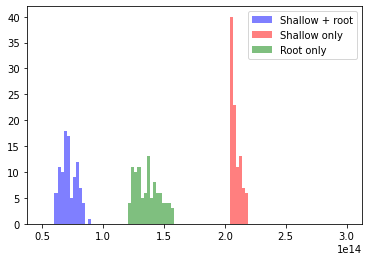

In [61]:
bins = np.linspace(5e13, 3e14, 100)

plt.hist(A1.df["error"], bins, facecolor='b', alpha=0.5, label = "Shallow + root")
plt.hist(A2.df["error"], bins, facecolor='r', alpha=0.5, label = "Shallow only")
plt.hist(A3.df["error"], bins, facecolor='g', alpha=0.5, label = "Root only")

plt.legend(loc='upper right')
plt.show()

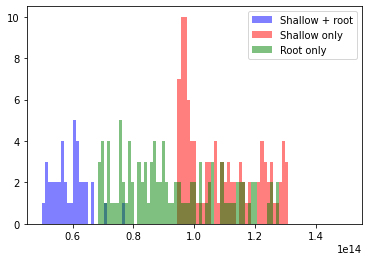

In [74]:
bins = np.linspace(5e13, 1.5e14, 100)

plt.hist(A1.df["error"], bins, facecolor='b', alpha=0.5, label = "Shallow + root")
plt.hist(A2.df["error"], bins, facecolor='r', alpha=0.5, label = "Shallow only")
plt.hist(A3.df["error"], bins, facecolor='g', alpha=0.5, label = "Root only")

plt.legend(loc='upper right')
plt.show()

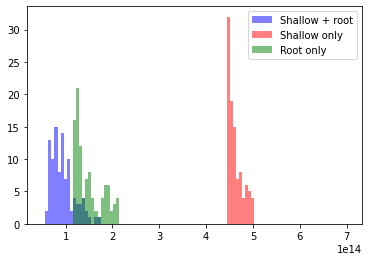

In [65]:
bins = np.linspace(5e13, 7e14, 100)

plt.hist(A4.df["error"], bins, facecolor='b', alpha=0.5, label = "Shallow + root")
plt.hist(A5.df["error"], bins, facecolor='r', alpha=0.5, label = "Shallow only")
plt.hist(A6.df["error"], bins, facecolor='g', alpha=0.5, label = "Root only")

plt.legend(loc='upper right')
plt.show()

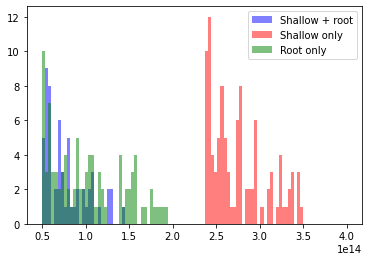

In [76]:
bins = np.linspace(5e13, 4e14, 100)

plt.hist(A4.df["error"], bins, facecolor='b', alpha=0.5, label = "Shallow + root")
plt.hist(A5.df["error"], bins, facecolor='r', alpha=0.5, label = "Shallow only")
plt.hist(A6.df["error"], bins, facecolor='g', alpha=0.5, label = "Root only")

plt.legend(loc='upper right')
plt.show()